In [1]:
import os
import json
import glob
import logging
import re
from langchain_openai import ChatOpenAI

In [2]:
# Load the API key and set the model name
file_path = "../keys.json"
with open(file_path, "r", encoding="utf-8") as file:
    key_data = json.load(file)

os.environ["OPENAI_API_KEY"] = key_data["openai_api_key"]
model_name = "gpt-4o-mini"

llm = ChatOpenAI(temperature=0, model_name=model_name)


In [3]:
def evaluate_two_outputs(output_A_path: str, output_B_path: str) -> dict:
    """
    Compare two outputs (mind maps) and return which one is preferred along with a brief explanation.
    
    The evaluation returns a JSON with the keys:
      - "preferred_output": "Output A", "Output B", or "Equal"
      - "overall_comment": Brief explanation highlighting the evaluation criteria (clarity, organization, detail, logical flow).
    """
    with open(output_A_path, 'r', encoding='utf-8') as f:
        output_A = f.read().strip()
    with open(output_B_path, 'r', encoding='utf-8') as f:
        output_B = f.read().strip()

    prompt = f"""
You are an expert evaluator for PPO RLHF labeling. Your task is to compare two outputs (mind maps) based on clarity, organization, detail, and logical flow.

Instructions:
- Determine which output is better overall.
- In your explanation, explicitly state which output is preferred ("Output A", "Output B", or "Equal") and provide a brief justification.
- Keep your explanation concise and focused on the criteria: clarity, organization, detail, and logical flow.
- Return your evaluation strictly in JSON format with the following keys (and no extra text):

{{
  "preferred_output": "Output A" or "Output B" or "Equal",
  "overall_comment": "brief explanation"
}}

Output A:
{output_A}

Output B:
{output_B}
    """

    messages = [
        {"role": "system", "content": "You are an objective evaluator for comparing two outputs."},
        {"role": "user", "content": prompt}
    ]
    
    response = llm(messages)
    text = response.content.strip()
    
    try:
        return json.loads(text)
    except json.JSONDecodeError:
        match = re.search(r"\{.*\}", text, re.S)
        if match:
            return json.loads(match.group())
        raise ValueError("Failed to parse evaluation response as JSON.")


In [4]:
def collect_data(dataset_directory_v1: str, dataset_directory_v2: str, output_file: str):
    """
    Process matching mind map files from two directories and save the evaluations.
    
    Parameters:
      - dataset_directory_v1: Directory containing version 1 mind map text files.
      - dataset_directory_v2: Directory containing version 2 mind map text files.
      - output_file: Full path to the output JSON file.
      
    The function expects that both directories have files with the same names.
    """
    evaluations = []
    logging.basicConfig(level=logging.INFO)
    
    # Get list of files from version 1 directory (assuming *.txt)
    files_v1 = glob.glob(os.path.join(dataset_directory_v1, "*.txt"))
    
    for file_path_v1 in files_v1:
        filename = os.path.basename(file_path_v1)
        file_path_v2 = os.path.join(dataset_directory_v2, filename)
        
        # Check if the corresponding file exists in version 2
        if not os.path.exists(file_path_v2):
            logging.warning(f"File {filename} not found in {dataset_directory_v2}, skipping.")
            continue
        
        try:
            eval_result = evaluate_two_outputs(file_path_v1, file_path_v2)
            evaluations.append({
                "filename": filename,
                "mind_map_v1_path": file_path_v1,
                "mind_map_v2_path": file_path_v2,
                "evaluation": eval_result
            })
            logging.info(f"Processed {filename}")
        except Exception as e:
            logging.error(f"Failed to process {filename}: {e}")
    
    # Write the evaluations to the output JSON file.
    with open(output_file, 'w', encoding='utf-8') as out_f:
        json.dump(evaluations, out_f, indent=2)
    
    print(f"Data collection complete. Evaluations saved to {output_file}")

In [7]:
if __name__ == "__main__":
    # Define the root directory for the test data
    root_dir = "../data/tqa_train_val_test/train/"
    
    # Construct the directories for the two versions
    dataset_directory_v1 = os.path.join(root_dir, "mindmap_text_v1")
    dataset_directory_v2 = os.path.join(root_dir, "mindmap_text_v2")
    
    # Define the output file path within the root directory
    output_file = os.path.join(root_dir, "pairwise_evaluations.json")
    
    # Call the data collection function with the constructed paths
    collect_data(dataset_directory_v1, dataset_directory_v2, output_file)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Processed mermaid_code_L_0370.txt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Processed mermaid_code_L_1067.txt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Processed mermaid_code_L_0198.txt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Processed mermaid_code_L_0260.txt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Processed mermaid_code_L_0293.txt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Processed mermaid_code_L_0946.txt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Processed mermaid_code_L_0664.txt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1

Data collection complete. Evaluations saved to ../data/tqa_train_val_test/train/pairwise_evaluations.json


In [5]:
mind_map_A_path = "../data/tqa_train_val_test/test/mindmap_text_v1/mermaid_code_L_0001.txt"
mind_map_B_path = "../data/tqa_train_val_test/test/mindmap_text_v2/mermaid_code_L_0001.txt"

# Call the evaluation function once and print the result.
evaluation = evaluate_two_ground_truths(mind_map_A_path, mind_map_B_path)
print("Evaluation Result:")
print(json.dumps(evaluation, indent=2))

/tmp/ipykernel_198031/3529554282.py:45: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(messages)


Evaluation Result:
{
  "cognitive_score": 5,
  "cognitive_comment": "Mind Map A presents a clearer flow of ideas with a more structured approach to the scientific method and experiment design, while Mind Map B introduces an example that adds context but slightly disrupts the thematic flow.",
  "structural_score": 6,
  "structural_comment": "Mind Map A is better organized with a clear hierarchy and grouping of related concepts, whereas Mind Map B, while also structured, has some elements that feel less cohesive due to the inclusion of an example that interrupts the flow."
}


In [11]:
mind_map_A_path = "../data/tqa_train_val_test/test/mindmap_text_v1/mermaid_code_L_0013.txt"
mind_map_B_path = "../data/tqa_train_val_test/test/mindmap_text_v2/mermaid_code_L_0013.txt"

# Call the evaluation function once and print the result.
evaluation = evaluate_two_outputs(mind_map_A_path, mind_map_B_path)
print("Evaluation Result:")
print(json.dumps(evaluation, indent=2))

Evaluation Result:
{
  "preferred_output": "Output A",
  "overall_comment": "Output A is preferred due to its clearer organization and more detailed explanations, particularly in the sections on adaptations and major eras, which enhance logical flow and understanding."
}


In [47]:
mind_map_B_path = "../data/tqa_train_val_test/test/mindmap_text_v1/mermaid_code_L_0013.txt"
mind_map_A_path = "../data/tqa_train_val_test/test/mindmap_text_v2/mermaid_code_L_0013.txt"

# Call the evaluation function once and print the result.
evaluation = evaluate_two_outputs(mind_map_A_path, mind_map_B_path)
print("Evaluation Result:")
print(json.dumps(evaluation, indent=2))

Evaluation Result:
{
  "overall_score": 5,
  "preferred_output": "Output B",
  "overall_comment": "Output B is clearer and more organized, with better detail and logical flow, particularly in the explanations of adaptations and fossil records."
}


In [9]:
mind_map_A_path = "../data/tqa_train_val_test/test/mindmap_text_v1/mermaid_code_L_0001.txt"
mind_map_B_path = "../data/tqa_train_val_test/test/mindmap_text_v2/mermaid_code_L_0001.txt"

# Call the evaluation function once and print the result.
evaluation = evaluate_two_outputs(mind_map_A_path, mind_map_B_path)
print("Evaluation Result:")
print(json.dumps(evaluation, indent=2))

Evaluation Result:
{
  "preferred_output": "Output B",
  "overall_comment": "Output B is preferred due to its clearer organization, inclusion of a specific experiment example that enhances detail, and better logical flow in explaining the differences between theories and hypotheses."
}


In [10]:
mind_map_B_path = "../data/tqa_train_val_test/test/mindmap_text_v1/mermaid_code_L_0001.txt"
mind_map_A_path = "../data/tqa_train_val_test/test/mindmap_text_v2/mermaid_code_L_0001.txt"

# Call the evaluation function once and print the result.
evaluation = evaluate_two_outputs(mind_map_A_path, mind_map_B_path)
print("Evaluation Result:")
print(json.dumps(evaluation, indent=2))

Evaluation Result:
{
  "preferred_output": "Output A",
  "overall_comment": "Output A is preferred due to its clearer organization and more detailed breakdown of the scientific method, including a specific experiment example that enhances understanding. It maintains a logical flow throughout the sections, making it easier to follow."
}


In [7]:
mind_map_A_path = "../data/tqa_train_val_test/test/mindmap_text_v1/mermaid_code_L_0005.txt"
mind_map_B_path = "../data/tqa_train_val_test/test/mindmap_text_v2/mermaid_code_L_0005.txt"

# Call the evaluation function once and print the result.
evaluation = evaluate_two_outputs(mind_map_A_path, mind_map_B_path)
print("Evaluation Result:")
print(json.dumps(evaluation, indent=2))

Evaluation Result:
{
  "preferred_output": "Output A",
  "overall_comment": "Output A is preferred due to its superior clarity, organization, and detail. It provides a comprehensive breakdown of concepts with clear definitions and mechanisms, ensuring a logical flow that enhances understanding. Output B lacks the same level of detail and organization, making it less effective in conveying the information."
}


In [8]:
mind_map_B_path = "../data/tqa_train_val_test/test/mindmap_text_v1/mermaid_code_L_0005.txt"
mind_map_A_path = "../data/tqa_train_val_test/test/mindmap_text_v2/mermaid_code_L_0005.txt"

# Call the evaluation function once and print the result.
evaluation = evaluate_two_outputs(mind_map_A_path, mind_map_B_path)
print("Evaluation Result:")
print(json.dumps(evaluation, indent=2))

Evaluation Result:
{
  "preferred_output": "Output B",
  "overall_comment": "Output B is preferred due to its greater clarity and detail, providing definitions and explanations that enhance understanding. It is better organized with a logical flow that connects concepts effectively, making it easier to follow."
}


In [9]:
import json
import os
import matplotlib.pyplot as plt
from collections import Counter

def read_evaluations(json_path):
    """
    Reads the JSON file containing pairwise evaluations and returns the data.
    """
    with open(json_path, 'r', encoding='utf-8') as f:
        evaluations = json.load(f)
    return evaluations

def plot_preferred_outputs(evaluations):
    """
    Plots a bar chart of how many evaluations preferred Output A, Output B, or were Equal.
    """
    # Extract the 'preferred_output' from each evaluation entry.
    preferred_outputs = []
    for entry in evaluations:
        # Each entry is expected to have an "evaluation" key containing a dict.
        ev = entry.get("evaluation", {})
        preferred = ev.get("preferred_output", "Unknown")
        preferred_outputs.append(preferred)
    
    # Count occurrences using Counter.
    counts = Counter(preferred_outputs)
    
    # Define the order for the categories.
    categories = ["Output A", "Equal", "Output B"]
    # Create a list of counts in the defined order; default to 0 if a category is missing.
    values = [counts.get(cat, 0) for cat in categories]
    
    # Plotting.
    plt.figure(figsize=(8, 6))
    bars = plt.bar(categories, values, color=['skyblue', 'lightgrey', 'salmon'])
    plt.xlabel("Preferred Output")
    plt.ylabel("Count")
    plt.title("Distribution of Preferred Outputs")
    
    # Annotate bar heights.
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f"{int(height)}", 
                 ha='center', va='bottom', fontsize=12)
    
    plt.tight_layout()
    plt.show()




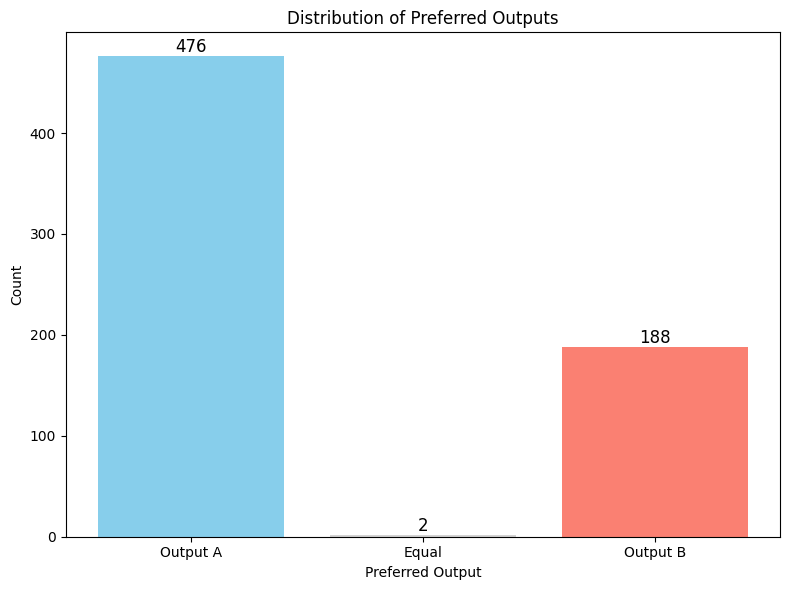

In [10]:

# Define the base directory for test data.
base_dir = "../data/tqa_train_val_test/train/"
json_path = os.path.join(base_dir, "pairwise_evaluations.json")

# Read evaluations from JSON.
evaluations = read_evaluations(json_path)

# Plot the distribution of the preferred output choices.
plot_preferred_outputs(evaluations)

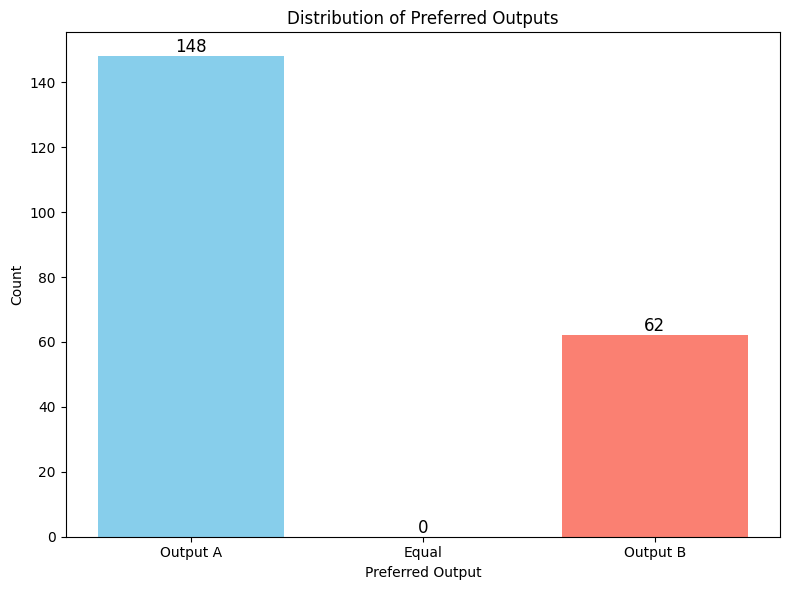

In [11]:

# Define the base directory for test data.
base_dir = "../data/tqa_train_val_test/test/"
json_path = os.path.join(base_dir, "pairwise_evaluations.json")

# Read evaluations from JSON.
evaluations = read_evaluations(json_path)

# Plot the distribution of the preferred output choices.
plot_preferred_outputs(evaluations)